<a href="https://colab.research.google.com/github/diegop2110/Talento_Tech/blob/main/Prediccion_plantvillage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os
import shutil

# Crear el directorio .kaggle
os.makedirs('/root/.kaggle', exist_ok=True)

# Copiar kaggle.json desde Google Drive a .kaggle
shutil.copy('/content/drive/My Drive/kaggle.json', '/root/.kaggle/')

# Establecer permisos correctos
os.chmod('/root/.kaggle/kaggle.json', 600)


In [6]:
!pip install kaggle
!kaggle datasets download -d abdallahalidev/plantvillage-dataset -p /content


Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
 99% 2.03G/2.04G [00:28<00:00, 163MB/s]
100% 2.04G/2.04G [00:28<00:00, 76.1MB/s]


In [7]:
!unzip /content/plantvillage-dataset.zip -d /content


Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e345153-aed9-4879-a2cc-24f9dc5100e7___UF.GRC_YLCV_Lab 01798_final_masked.jpg  
  inflating: /content/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e37e8ad-3944-4e11-bc10-dd82616274d7___YLCV_NREC 2915_final_masked.jpg  
  inflating: /content/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e382244-fb3a-4caa-af71-05fff25f1c27___UF.GRC_YLCV_Lab 03397_final_masked.jpg  
  inflating: /content/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e3b9886-ce13-49d5-8f80-ccf4e5ddbeac___YLCV_GCREC 5479_final_masked.jpg  
  inflating: /content/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e615038-7a87-446a-a2cd-f76c5c75b6dd___YLCV_GCREC 5144_final_masked.jpg  
  inflating: /content/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e6938

In [9]:
shutil.move('//content/plantvillage dataset', '/content/drive/My Drive/plantvillage-dataset')


'/content/drive/My Drive/plantvillage-dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


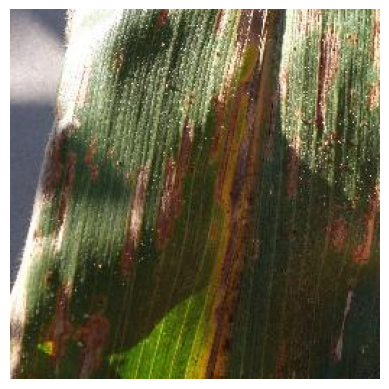

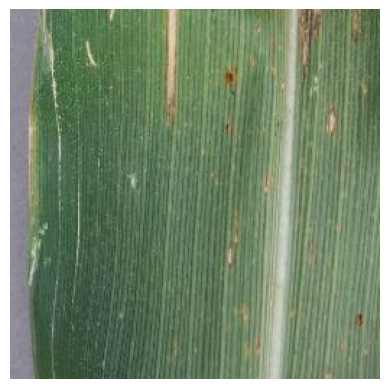

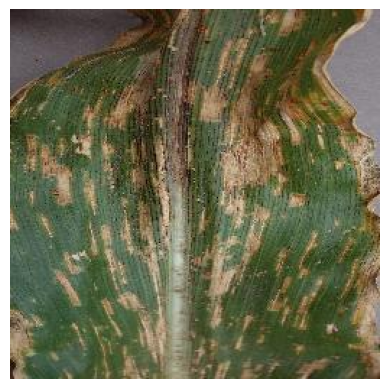

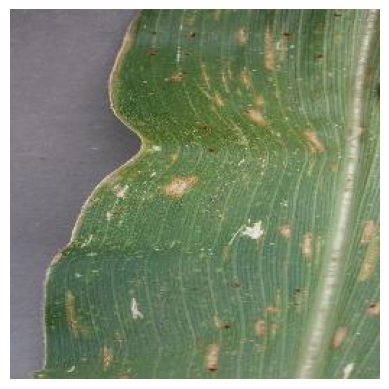

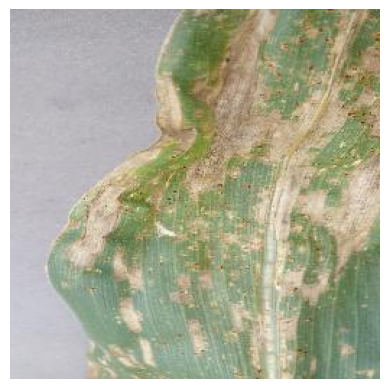

In [7]:
from google.colab import drive
import os
from PIL import Image
import matplotlib.pyplot as plt

# Montar Google Drive
drive.mount('/content/drive')

# Definir la ruta a las carpetas de imágenes
base_path = '/content/drive/My Drive/plantvillage-dataset/'
color_path = os.path.join(base_path, 'color')
gray_path = os.path.join(base_path, 'gray')
segmented_path = os.path.join(base_path, 'segmented')

# Función para mostrar imágenes
def show_images_from_folder(folder_path, num_images=5):
    image_files = []

    # Recorrer todas las subcarpetas y archivos
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(os.path.join(root, file))

    # Tomar las primeras `num_images` imágenes
    for image_file in image_files[:num_images]:
        img = Image.open(image_file)
        plt.imshow(img)
        plt.axis('off')  # Ocultar los ejes
        plt.show()

# Mostrar imágenes de la carpeta 'color'
show_images_from_folder(color_path)


In [8]:
!pip install tensorflow


In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [10]:
train_dir = '/content/drive/My Drive/plantvillage-dataset/color'


In [11]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Separar un 20% de los datos para validación
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Tamaño al que se redimensionarán las imágenes
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Usar el subset para entrenamiento
)

validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Usar el subset para validación
)


Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10  # Número de épocas a entrenar
)


Epoch 1/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2744s 2s/step - accuracy: 0.8426 - loss: 0.4880 - val_accuracy: 0.8976 - val_loss: 0.3108
Epoch 2/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 71us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.4848
Epoch 3/15


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2537s 2s/step - accuracy: 0.9172 - loss: 0.2499 - val_accuracy: 0.9074 - val_loss: 0.2733
Epoch 4/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 34us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 5/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2471s 2s/step - accuracy: 0.9453 - loss: 0.1647 - val_accuracy: 0.9288 - val_loss: 0.2202
Epoch 6/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 44us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 4.0531e-06
Epoch 7/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2512s 2s/step - accuracy: 0.9606 - loss: 0.1172 - val_accuracy: 0.9288 - val_loss: 0.2223
Epoch 8/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 52us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 9/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2505s 2s/step - accuracy: 0.9687 - loss: 0.0923 - val_accuracy: 0.9281 - val_loss: 0.2300
Epoch 10/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - a

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


340/340 ━━━━━━━━━━━━━━━━━━━━ 3247s 10s/step


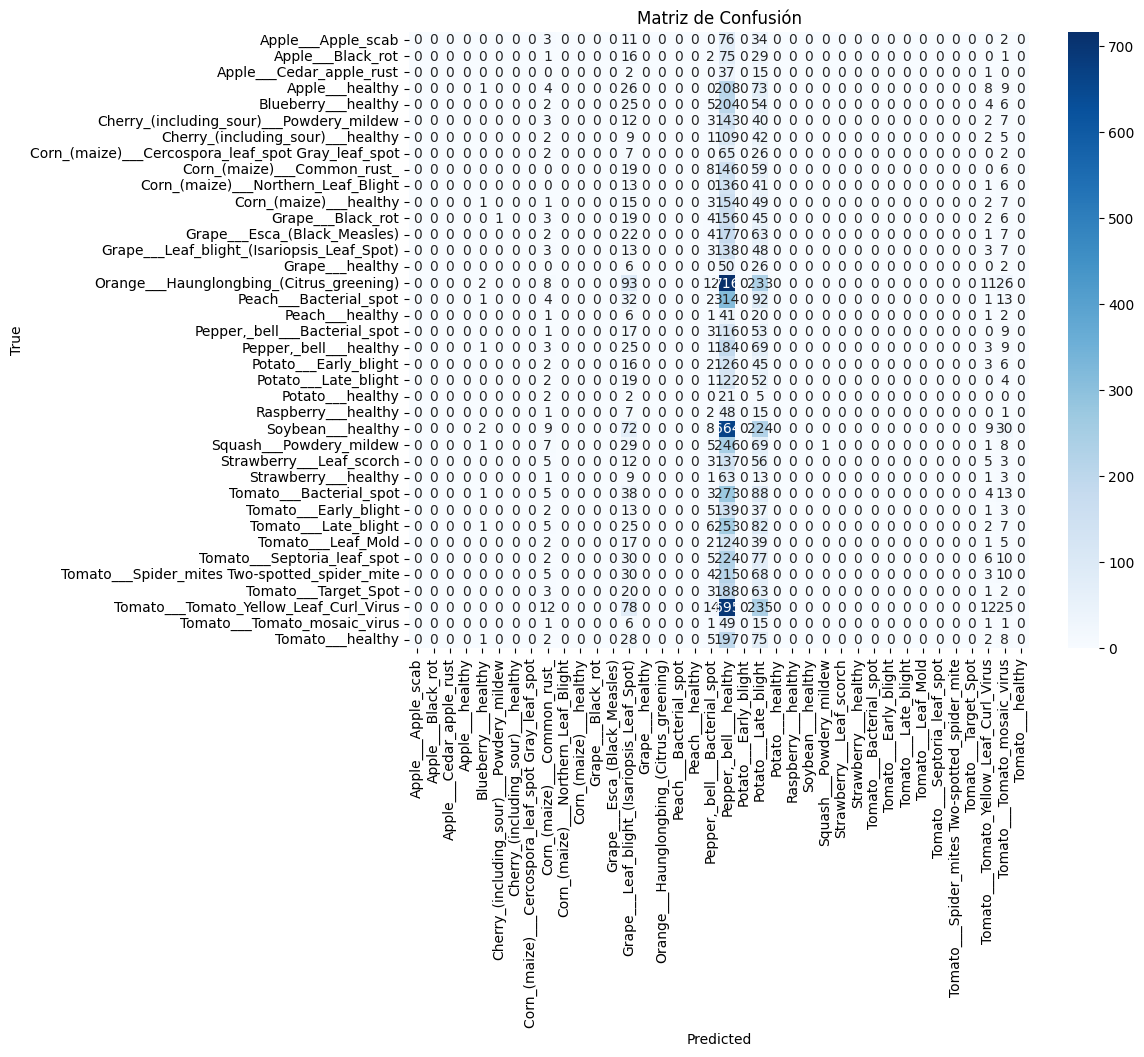

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.00      0.00      0.00       126
                                 Apple___Black_rot       0.00      0.00      0.00       124
                          Apple___Cedar_apple_rust       0.00      0.00      0.00        55
                                   Apple___healthy       0.00      0.00      0.00       329
                               Blueberry___healthy       0.00      0.00      0.00       300
          Cherry_(including_sour)___Powdery_mildew       0.00      0.00      0.00       210
                 Cherry_(including_sour)___healthy       0.00      0.00      0.00       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00       102
                       Corn_(maize)___Common_rust_       0.00      0.00      0.00       238
               Corn_(maize)___Northern_Leaf_Blight       0.00      0.00      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener predicciones del conjunto de validación
validation_generator.reset()  # Reiniciar el generador de validación
pred = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
predicted_classes = np.argmax(pred, axis=1)

# Obtener etiquetas verdaderas del conjunto de validación
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()

# Calcular y mostrar el reporte de clasificación
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

!pip install scikit-learn


In [3]:
# Definir las rutas de las carpetas
train_dir = '/content/drive/My Drive/plantvillage-dataset/color'

# Crear un generador de imágenes con aumento de datos
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


In [4]:
# Utilizar un modelo preentrenado (Transfer Learning)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')
])

for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Entrenar el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=5
)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1312/1358 ━━━━━━━━━━━━━━━━━━━━ 16:01 21s/step - accuracy: 0.5943 - loss: 1.5327